# Multi-Class Classification Lab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import files

In [3]:
!cp /content/drive/MyDrive/Datasets/lab_utils_multiclass_TF.py /content

In [4]:
!cp /content/drive/MyDrive/Datasets/deeplearning.mplstyle /content

In [8]:
!cp /content/drive/MyDrive/Datasets/lab_utils_common.py /content

In [6]:
pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.9 MB/s eta 0:00:00


In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from sklearn.datasets import make_blobs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
np.set_printoptions(precision=2)
from lab_utils_multiclass_TF import *
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

# Multi-class Classification
Neural Networks are often used to classify data. Examples are neural networks:
- take in photos and classify subjects in the photos as {dog,cat,horse,other}
- take in a sentence and classify the 'parts of speech' of its elements: {noun, verb, adjective etc..}  

A network of this type will have multiple units in its final layer. Each output is associated with a category. When an input example is applied to the network, the output with the highest value is the category predicted. If the output is applied to a softmax function, the output of the softmax will provide probabilities of the input being in each category.

In this lab you will see an example of building a multiclass network in Tensorflow. We will then take a look at how the neural network makes its predictions.

Let's start by creating a four-class data set.

### Preparing and Visualize our Data
We will use Scikit-Learn `make_blobs` function to make a training data set with 4 categories as shown in the plot below.

In [10]:
# makinh 4-class dataset for classification
classes = 4
m = 100
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
std = 1.0
X_train, y_train = make_blobs(n_samples=m, centers=centers, cluster_std=std,random_state=30)

/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


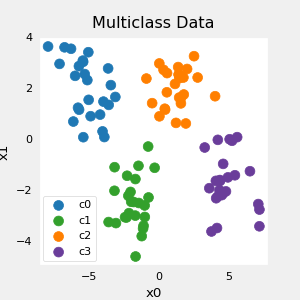

In [11]:
plt_mc(X_train,y_train,classes, centers, std=std)

In [12]:
from google.colab import output
output.enable_custom_widget_manager()

Each dot represents a training example. The axis (x0,x1) are the inputs and the color represents the class the example is associated with. Once trained, the model will be presented with a new example, (x0,x1), and will predict the class.  

While generated, this data set is representative of many real-world classification problems. There are several input features (x0,...,xn) and several output categories. The model is trained to use the input features to predict the correct output category.

In [13]:
# show classes in data set
print(f"Unique Classes {np.unique(y_train)}")
# show how classes are represented
print(f"Class Representation {y_train[:10]}")
# show shapes of our dataset
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")

Unique Classes [0 1 2 3]
Class Representation [3 3 3 0 3 3 3 3 2 0]
Shape of X_train: (100, 2), Shape of y_train: (100,)


## Model
Unlike the binary classification networks, this network has four outputs, one for each class. Given an input example, the output with the highest value is the predicted class of the input.   

Below is an example of how to construct this network in Tensorflow. Notice the output layer uses a `linear` rather than a `softmax` activation. While it is possible to include the softmax in the output layer, it is more numerically stable if linear outputs are passed to the loss function during training. If the model is used to predict probabilities, the softmax can be applied at that point.

In [14]:
tf.random.set_seed(1234)# applied to achieve consistent results
model = Sequential(
    [
        Dense(2, activation = 'relu',   name = "L1"),
        Dense(4, activation = 'linear', name = "L2")
    ]
)

The statements below compile and train the network. Setting `from_logits=True` as an argument to the loss function specifies that the output activation was linear rather than a softmax.

In [15]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
)

model.fit(
    X_train,y_train,
    epochs=200
)

Epoch 1/200
4/4 [==============================] - 2s 16ms/step - loss: 2.9172
Epoch 2/200
4/4 [==============================] - 0s 5ms/step - loss: 2.6490
Epoch 3/200
4/4 [==============================] - 0s 5ms/step - loss: 2.4088
Epoch 4/200
4/4 [==============================] - 0s 4ms/step - loss: 2.2100
Epoch 5/200
4/4 [==============================] - 0s 3ms/step - loss: 2.0254
Epoch 6/200
4/4 [==============================] - 0s 3ms/step - loss: 1.8602
Epoch 7/200
4/4 [==============================] - 0s 3ms/step - loss: 1.7195
Epoch 8/200
4/4 [==============================] - 0s 4ms/step - loss: 1.5900
Epoch 9/200
4/4 [==============================] - 0s 3ms/step - loss: 1.4810
Epoch 10/200
4/4 [==============================] - 0s 3ms/step - loss: 1.3775
Epoch 11/200
4/4 [==============================] - 0s 3ms/step - loss: 1.2875
Epoch 12/200
4/4 [==============================] - 0s 3ms/step - loss: 1.2070
Epoch 13/200
4/4 [==============================] - 0s 3ms/s

With the model trained, we can see how the model has classified the training data.

184/184 [==============================] - 1s 3ms/step


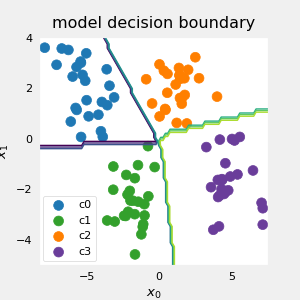

In [16]:
plt_cat_mc(X_train, y_train, model, classes)

Above, the decision boundaries show how the model has partitioned the input space.  This very simple model has had no trouble classifying the training data.<br>
**How did it accomplish this?**<br>
Below, we will pull the trained weights from the model and use that to plot the function of each of the network units. Further down, there is a more detailed explanation of the results. You don't need to know these details to successfully use neural networks, but it may be helpful to gain more intuition about how the layers combine to solve a classification problem.

In [17]:
# gather the trained parameters from the first layer
l1 = model.get_layer("L1")
W1,b1 = l1.get_weights()

/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


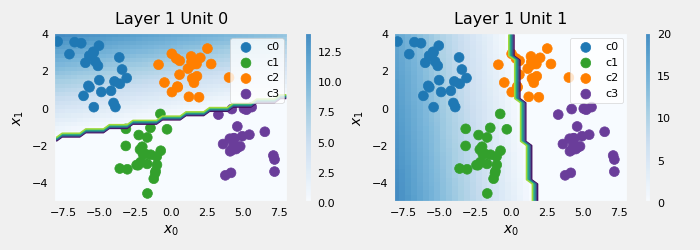

In [18]:
# plot the function of the first layer
plt_layer_relu(X_train, y_train.reshape(-1,), W1, b1, classes)

/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


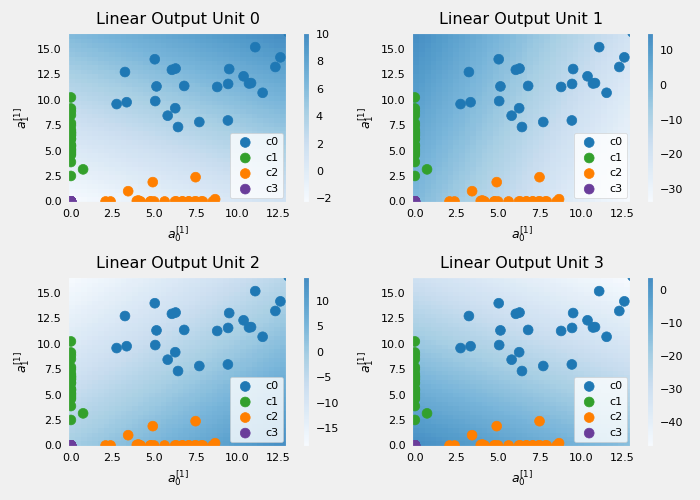

In [19]:
# gather the trained parameters from the output layer
l2 = model.get_layer("L2")
W2, b2 = l2.get_weights()
# create the 'new features', the training examples after L1 transformation
Xl2 = np.maximum(0, np.dot(X_train,W1) + b1)

plt_output_layer_linear(Xl2, y_train.reshape(-1,), W2, b2, classes,
                        x0_rng = (-0.25,np.amax(Xl2[:,0])), x1_rng = (-0.25,np.amax(Xl2[:,1])))